In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re
from pathlib import Path
from tqdm import tqdm
import json
#import pickle5 as pickle
import pickle
import numpy as np
import collections
import jieba
from collections import Counter
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics  import f1_score,accuracy_score, confusion_matrix
from sklearn.ensemble import  RandomForestClassifier
import fasttext
import fasttext.util
import jieba #tokenized = list(jieba.cut((line)))
#ft = fasttext.load_model('../fastText/cc.zh.300.bin')
import sklearn_crfsuite

#from sklearn_crfsuite import scorers
import numpy as np
#from sklearn_crfsuite import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn import metrics

In [2]:

fasttext.util.reduce_model(ft, 100)
print(ft.get_dimension())

100


In [5]:
!python --version

Python 3.6.8 :: Anaconda, Inc.


In [78]:
%ls ../CRECIL/Final_Data

dev.json  shuffle_data.py  test.json  train_1.json  train.json


In [2]:
with open('../CRECIL/Final_Data/train.json','rb') as infile:
    train_df = json.loads(infile.read())
    
#override
"""
with open('../CRECIL/Final_Data/train_1.json','rb') as infile:
    train_df= pickle.load(infile)
"""
with open('../CRECIL/Final_Data/train_1.pickle','rb') as infile:
    train_df= pickle.load(infile)
    
with open('../CRECIL/Final_Data/dev.json','rb') as infile:
    dev_df = json.loads(infile.read())
    
# save version with extra field for tokenized/prepped dialogues
with open('../CRECIL/Final_Data/dev_1.pickle','rb') as infile:
    dev_df= pickle.load(infile)
    
with open('../CRECIL/Final_Data/test.json','rb') as infile:
    test_df = json.loads(infile.read())
    
with open('../CRECIL/Final_Data/test_1.pickle','rb') as infile:
    test_df= pickle.load(infile)
    
#data load
with open('../CRECIL/My_home_data/partition1.pickle','rb') as infile:
    partition1 = pickle.load(infile)
    
with open('rid_to_rel.pickle','rb') as infile:
    rid_to_rel = pickle.load(infile)

with open('rel_to_rid.pickle','rb') as infile:
    rel_to_rid = pickle.load(infile)

In [3]:
def get_blank_relations(annotations:list) -> list:
    """
    Take the labels and clear out the gold-standard relations, 
    to be filled with predictions by model
    """
    pred_list =[]
    
    for item in annotations:
        copy = item.copy()
        copy['r'] = []
        copy['rid'] = []
        pred_list.append(copy)
    
    return pred_list


def ch_tokenizer(input_str:str):
    #tokenize sentence and return as list
    tokenized = list(jieba.cut(input_str))
    return tokenized

def get_num_speakers(transcript:list)-> int:
    """
    return number of speakers in scene
    """
    ch_set = set()
    for line in transcript:
        ch_set.add(re.findall('S.*(?=:)',line)[0])
    
    total = len(ch_set)
    return total

def dummy_tokenize(phrase): #pass tokenized text version
    return phrase

class results:
    """
    Make an object of the results so that I can get accurate numbers and confusion 
    matrices while sorting for labels.
    """
    def __init__(self,y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.labels = sorted(list(set(y_test)))
        self.cm = pd.DataFrame(np.zeros(shape=(len(self.labels),len(self.labels)+1))) #initialize to empty
        self.cm[0]=self.labels
        self.cm.columns = ['pred']+self.labels
        self.accuracy = 0
        self.correct = 0
        self.incorrect = 0
        self.label_metrics = dict()
        
        for lab in self.labels:
            self.label_metrics[lab] = dict()
            self.label_metrics[lab]['F1'] = 0.0
            self.label_metrics[lab]['Recall'] = 0.0
            self.label_metrics[lab]['Accuracy'] = 0.0
            self.label_metrics[lab]['TP'] = 0
            self.label_metrics[lab]['TN'] = 0
            self.label_metrics[lab]['FP'] = 0
            self.label_metrics[lab]['FN'] = 0
            self.label_metrics[lab]['cm'] = pd.DataFrame(np.zeros(shape=(2,3)),\
                                                         columns=['']+['Test P','Test N']) #initialize to empty
            self.label_metrics[lab]['cm'][0] = ['Pred P','Pred N']
        
        for i in range(0,len(y_test)):
            
            #update CM
            self.cm.loc[ self.cm['pred'] == y_pred[i], y_test[i]] +=1
            
            if y_pred[i]==y_test[i]:
                self.correct +=1
                self.label_metrics[y_test[i]]['TP'] +=1
                for lab in self.labels:
                    if lab != y_test[i]:
                        self.label_metrics[lab]['TN'] +=1 #all other incorrect labels were not selected
            else:
                self.incorrect +=1
                self.label_metrics[y_test[i]]['FN'] += 1 #true label was not selected
                self.label_metrics[y_pred[i]]['FP'] +=1 #a wrong label was selected
                
                
        self.accuracy = self.correct/(self.correct+self.incorrect)
        for lab in self.labels:
            
            try:
                self.label_metrics[lab]['Precision'] = self.label_metrics[lab]['TP']/(self.label_metrics[lab]['TP']+self.label_metrics[lab]['FP'])
                self.label_metrics[lab]['Recall'] = self.label_metrics[lab]['TP']/(self.label_metrics[lab]['TP']+self.label_metrics[lab]['FN'])
                self.label_metrics[lab]['F1'] = self.label_metrics[lab]['TP']/(self.label_metrics[lab]['TP']+(0.5)*(self.label_metrics[lab]['FP']+self.label_metrics[lab]['FN']))      
                
            except:
                self.label_metrics[lab]['Precision'] = 0
                self.label_metrics[lab]['Recall'] = 0
                self.label_metrics[lab]['F1'] = 0
    def cm(self):
        """
        show cm
        """
        return(self.cm)
    
    def metric(self):
        
        
        print(f"Overall accuracy = {self.accuracy}")
        
        for lab in self.labels:
            print(f"{lab}: {len([item for item in y_test if item==lab])} total")
            print(f"   F1={self.label_metrics[lab]['F1']}")
            print(f"   Precision={self.label_metrics[lab]['Precision']}")
            print(f"   Recall={self.label_metrics[lab]['Recall']}")

        pass


def jb_tokenize(line:str)-> list:
    return list(jieba.cut((line)))


def retrieve_s_lines(speaker:str,dialog:str)-> list:
    lines =[]
    
    for line in dialog:
        if line[0]==speaker:
            lines.append(line[1])
    return lines



def retrieve_mentions(ch:str,dialog:str)-> list:
    lines =[]
    
    for line in dialog:
        if bool(re.search(ch,line[1])):
            lines.append(line[1])
    return lines

def get_avg_embeddings(array:list)-> dict:
    """Input array is list of sentences, output is a dictionary with the 
    average embeddings of those sentences.
    """
    
    embeddings = []
    for item in array:
        embeddings.append(ft.get_sentence_vector(item))
    avg_embeddings = np.mean(embeddings, axis=0)
    
    return avg_embeddings

def embeddings_to_features(array:list)-> dict:
    
    features = {}
    for iv,value in enumerate(array):
        features['v{}'.format(iv)]=value
    
    return features

In [74]:
y_test_unlist = [item[0] for item in y_test]
y_test_unlist = [item[0] for item in y_test_predict]

In [76]:
y_test_unlist

['per:relative',
 'per:spouse',
 'per:parents',
 'per:alternate_name',
 'per:parents',
 'per:relative',
 'per:relative',
 'per:siblings',
 'per:relative',
 'per:relative',
 'per:relative',
 'per:alternate_name',
 'per:spouse',
 'per:siblings',
 'per:parents',
 'per:spouse',
 'per:parents',
 'per:siblings',
 'per:children',
 'per:relative',
 'per:children',
 'per:children',
 'per:alternate_name',
 'per:relative',
 'per:alternate_name',
 'per:relative',
 'per:spouse',
 'per:parents',
 'per:parents',
 'per:relative',
 'per:children',
 'per:relative',
 'per:children',
 'per:alternate_name',
 'per:children',
 'per:relative',
 'per:relative',
 'per:alternate_name',
 'per:siblings',
 'per:relative',
 'per:relative',
 'per:relative',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'per:children',
 'unanswerable',
 'unanswerable',
 'unanswerable',
 'per:alternate_name',
 'unanswerable',
 'per:parents',
 'unanswerable',
 'un

In [77]:
crf_results = results(y_test_unlist,y_pred)

In [78]:
crf_results.cm

,pred,per:acquaintance,per:alternate_name,per:boss,per:boyfriend,per:children,per:children-in-law,per:classmate,per:client,per:colleague,...,per:parents-in-law,per:positive impression,per:relative,per:siblings,per:siblings-in-law,per:spouse,per:student,per:subordinate,per:teacher,unanswerable
0,per:acquaintance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,per:alternate_name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,per:boss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,per:boyfriend,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,per:children,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,per:children-in-law,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,per:classmate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,per:client,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,per:colleague,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,per:dates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
import pandas as pd

In [77]:
!pip install pandas

     |████████████████████████████████| 9.5 MB 3.6 MB/s eta 0:00:01
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)


In [4]:
# save version with extra field for tokenized/prepped dialogues
with open('../CRECIL/Final_Data/train_1.pickle','wb') as outfile:
    pickle.dump(train_df,outfile,protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# save version with extra field for tokenized/prepped dialogues
with open('../CRECIL/Final_Data/dev_1.pickle','wb') as outfile:
    pickle.dump(dev_df,outfile,protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# save version with extra field for tokenized/prepped dialogues
with open('../CRECIL/Final_Data/test_1.pickle','wb') as outfile:
    pickle.dump(test_df,outfile,protocol=pickle.HIGHEST_PROTOCOL)

### Question 1: 
how does per:alternate_name get predicted, if we have masked names? <br/>
**Answer**: "The model's input consists of a dialogue and a character entity pair to be recognized". I take this to mean that the pairs of entities within the dialogue are given, so models don't have to recreate the pairs from the dialogue itself.

In [10]:
rid_to_rel = Counter() #given an rid, return the relation
rel_to_rid = dict() #given a relation, return the rid

for item in train_df:
    for rel in item[1]:
        
        for i in range(0,len(rel['r'])):
            if rel['r'][i] not in rel_to_rid:
                rel_to_rid[rel['r'][i]] = rel['rid'][i]
            if rel['rid'][i] not in rid_to_rel:
                rid_to_rel[rel['rid'][i]] = rel['r'][i]
                
rid_to_rel = collections.OrderedDict(sorted(rid_to_rel.items()))

In [66]:
with open('rid_to_rel.pickle','wb') as outfile:
    pickle.dump(rid_to_rel,outfile,protocol=pickle.HIGHEST_PROTOCOL)

with open('rel_to_rid.pickle','wb') as outfile:
    pickle.dump(rel_to_rid,outfile,protocol=pickle.HIGHEST_PROTOCOL)

Watch [this link](https://www.google.com/search?q=add+features+feature+engineering+one-hot+encoding+with+bert&oq=add+features+feature+engineering+one-hot+encoding+with+bert&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRigAdIBCTExODI1ajBqN6gCALACAA&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:66503114,vid:NbbsVcs42jE)

Analysis: make a correlation matrix among the 32 relations. Surely per:parent and per:child must occur together frequently

In [38]:
total_dev = 0
for i in range(0,len(dev_df)):
    total_dev += len(dev_df[i][1])
total_dev

7422

In [13]:
len(rid_to_rel)

32

In [86]:
#create empty data frame
zero_data = np.zeros(shape=(len(train_df),len(rid_to_rel)))
gt_df = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(train_df)):
    for rel_item in train_df[i][1]:
        for j in rel_item['rid']:
            gt_df.iat[i,j] = 1

In [100]:
Counter(gt_df['per:alternate_name'])

Counter({1.0: 429, 0.0: 53})

In [88]:
corr_matrix = gt_df.corr()

In [89]:
corr_matrix

,per:alternate_name,per:children,per:parents,per:acquaintance,per:client,per:colleague,per:ex-girlfriend,per:girlfriend,per:dates,per:ex-boyfriend,...,per:siblings,per:spouse,per:grandparents,per:grandchildren,per:teacher,per:student,per:roommate,per:relative,per:siblings-in-law,unanswerable
per:alternate_name,1.000000,0.117070,0.117070,0.055997,0.080460,0.085296,0.069229,0.078680,0.063102,0.069229,...,0.069274,0.108441,0.092696,0.092696,0.048484,0.048484,0.016026,0.095654,0.042669,0.090971
per:children,0.117070,1.000000,1.000000,-0.006048,-0.033970,-0.037705,-0.128090,-0.150463,-0.115819,-0.128090,...,0.268160,0.516230,0.402224,0.402224,-0.020470,-0.020470,0.027564,0.271393,0.034214,0.099455
per:parents,0.117070,1.000000,1.000000,-0.006048,-0.033970,-0.037705,-0.128090,-0.150463,-0.115819,-0.128090,...,0.268160,0.516230,0.402224,0.402224,-0.020470,-0.020470,0.027564,0.271393,0.034214,0.099455
per:acquaintance,0.055997,-0.006048,-0.006048,1.000000,-0.043498,-0.021592,-0.022164,-0.013124,0.058844,-0.022164,...,0.039423,0.093797,0.092402,0.092402,0.069985,0.069985,-0.019263,-0.043313,-0.051286,0.027149
per:client,0.080460,-0.033970,-0.033970,-0.043498,1.000000,0.099027,-0.045087,-0.051243,-0.058975,-0.045087,...,-0.081649,-0.087550,-0.056349,-0.056349,-0.031576,-0.031576,-0.010438,-0.102300,-0.027789,0.131067
per:colleague,0.085296,-0.037705,-0.037705,-0.021592,0.099027,1.000000,-0.048390,-0.034804,0.043607,-0.048390,...,-0.139865,-0.025027,-0.025115,-0.025115,-0.055904,-0.055904,-0.018479,-0.099105,0.249716,0.149115
per:ex-girlfriend,0.069229,-0.128090,-0.128090,-0.022164,-0.045087,-0.048390,1.000000,0.777210,0.538054,1.000000,...,-0.005680,-0.064143,-0.031815,-0.031815,0.134502,0.134502,-0.008981,0.045175,-0.023910,0.112771
per:girlfriend,0.078680,-0.150463,-0.150463,-0.013124,-0.051243,-0.034804,0.777210,1.000000,0.506325,0.777210,...,-0.054955,-0.097220,-0.069105,-0.069105,0.041021,0.041021,-0.010207,0.005557,-0.027174,0.128167
per:dates,0.063102,-0.115819,-0.115819,0.058844,-0.058975,0.043607,0.538054,0.506325,1.000000,0.538054,...,-0.020943,-0.107310,-0.059057,-0.059057,0.027903,0.027903,-0.011747,0.053030,-0.031275,0.087760
per:ex-boyfriend,0.069229,-0.128090,-0.128090,-0.022164,-0.045087,-0.048390,1.000000,0.777210,0.538054,1.000000,...,-0.005680,-0.064143,-0.031815,-0.031815,0.134502,0.134502,-0.008981,0.045175,-0.023910,0.112771


In [96]:
sort(corr_matrix['per:boss'])

[('per:acquaintance', -0.08208033022655042),
 ('per:alternate_name', 0.04169164806752479),
 ('per:boss', 1.0),
 ('per:boyfriend', 0.168066785272256),
 ('per:children', 0.0328757046813823),
 ('per:children-in-law', 0.132118874953544),
 ('per:classmate', 0.03727483722089884),
 ('per:client', -0.034528935855916675),
 ('per:colleague', -0.10766179874679062),
 ('per:dates', 0.09941876083041462),
 ('per:ex-boyfriend', 0.17851966356077914),
 ('per:ex-girlfriend', 0.17851966356077914),
 ('per:friends', -0.09633133550269961),
 ('per:girlfriend', 0.168066785272256),
 ('per:grandchildren', 0.1253900217410204),
 ('per:grandparents', 0.1253900217410204),
 ('per:negative impression', 0.10295738431118671),
 ('per:neighbor', -0.025789516339307476),
 ('per:nickname', -0.0254849056436838),
 ('per:nurse', 0.7588329056007194),
 ('per:parents', 0.0328757046813823),
 ('per:parents-in-law', 0.132118874953544),
 ('per:positive impression', -0.019749396565728463),
 ('per:relative', 0.38772870409144783),
 ('per

Here's a show-specific variable: dialogue-size. I wonder if the rarer relation labels aren't more common only in larger group settings than smaller?

In [116]:
get_num_speakers(train_df[0][0])

4

In [ ]:
#copy code from prev work. 

Main deliberation: these sets of y-variables are co-dependent. Some are very likely to occur together, but it seems harder to model a scenario where a model predicts 5 out of 10 relations, than individually asking: is this relation present or not? 

I'm going to start with the latter problem because I know how to set it up, and then I'm going to research and brainstorm how to set up the first problem.

Short term goal: set up a model that can make predictions based on basic features, and be able to run the evaluation script on it. 

**Step 1**: make a gt data frame with present relations for each dialogue

In [16]:
zero_data = np.zeros(shape=(len(train_df),len(rid_to_rel))) #change length
train_gt = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(train_df)):
    for rel_item in train_df[i][1]:
        for j in rel_item['rid']:
            train_gt.iat[i,j] = 1

zero_data = np.zeros(shape=(len(dev_df),len(rid_to_rel)))
dev_gt = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(dev_df)):
    for rel_item in dev_df[i][1]:
        for j in rel_item['rid']:
            dev_gt.iat[i,j] = 1

zero_data = np.zeros(shape=(len(test_df),len(rid_to_rel)))
test_gt = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(test_df)):
    for rel_item in test_df[i][1]:
        for j in rel_item['rid']:
            test_gt.iat[i,j] = 1

In [17]:
train_array = []
for i in range(0,len(train_df)):
    
    temp = ""
    for row in train_df[i][0]:
        temp += row + '\n'
    train_array.append(temp)

dev_array = []
for i in range(0,len(dev_df)):
    
    temp = ""
    for row in dev_df[i][0]:
        temp += row + '\n'
    dev_array.append(temp)
    
test_array = []
for i in range(0,len(test_df)):
    
    temp = ""
    for row in test_df[i][0]:
        temp += row + '\n'
    test_array.append(temp)

In [12]:
cv = CountVectorizer(tokenizer=ch_tokenizer,ngram_range=(1,3),min_df=2,max_df=0.55)
#train_array,
count_vector=cv.fit_transform(train_array)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.459 seconds.
Prefix dict has been built successfully.


In [13]:
X_train = count_vector.toarray()

In [21]:
#rename for consistency
y_train = train_gt
y_test = test_gt

In [28]:
len(dev_gt)

116

In [24]:
# Create feature matrix

#split data if needed
y = train_gt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




In [29]:
y_train.columns

Index(['per:alternate_name', 'per:children', 'per:parents', 'per:acquaintance',
       'per:client', 'per:colleague', 'per:ex-girlfriend', 'per:girlfriend',
       'per:dates', 'per:ex-boyfriend', 'per:boyfriend', 'per:friends',
       'per:nickname', 'per:neighbor', 'per:nurse', 'per:parents-in-law',
       'per:children-in-law', 'per:positive impression', 'per:classmate',
       'per:negative impression', 'per:subordinate', 'per:boss',
       'per:siblings', 'per:spouse', 'per:grandparents', 'per:grandchildren',
       'per:teacher', 'per:student', 'per:roommate', 'per:relative',
       'per:siblings-in-law', 'unanswerable'],
      dtype='object')

In [22]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train['per:roommate']).predict(X_test)

In [23]:
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test['per:roommate'] != y_pred).sum()))
Counter(y_pred) 

Number of mislabeled points out of a total 71 points : 0


Counter({0.0: 71})

In [33]:

#fit
SVM = SVC(kernel = 'linear')
SVM.fit(X_train,y_train['per:roommate'])
y_pred=SVM.predict(X_dev)

In [34]:
print("Number of mislabeled points out of a total %d points : %d"% (X_dev.shape[0], (dev_gt['per:roommate'] != y_pred).sum()))
Counter(y_pred)

Number of mislabeled points out of a total 116 points : 0


Counter({0.0: 116})

In [29]:
#evaluate
print(accuracy_score(y_test['per:roommate'],y_pred))
print(f1_score(y_test['per:roommate'],y_pred))
confusion_matrix(y_test['per:roommate'], y_pred) #even more the case than the Logistic Regression

1.0
0.0


/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


array([[71]])

In [ ]:

neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()[::-1]

In [ ]:


"""
clf.classes_  gives array(['tu', 'vous'], dtype='<U4')
so the second one, 1, is vous, and that's what's getting shown in the 
pos_class
"""
print(clf.classes_)
print(np.take(count.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count.get_feature_names(), pos_class_prob_sorted[:10])) 

Jul 14

In [8]:
#make ground truth of 9 labels 
y = []
X = []
for scene in partition1:
    for line in scene:
        y.append(line['rel_pair'])
        #remove non-characters
        no_punct = [word for word in line['tokenized'] if bool(re.search(r'[\u4e00-\u9fff]',word))] 
        X.append(no_punct)
Counter(y)

Counter({'children_parents': 115,
         'parents_children': 117,
         'relative_relative': 36,
         'siblings_siblings': 10,
         'spouse_spouse': 454,
         'grandparents_grandchildren': 77,
         'grandchildren_grandparents': 73,
         'parents-in-law_children-in-law': 229,
         'children-in-law_parents-in-law': 235})

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
Counter(y_test)

Counter({'children_parents': 27,
         'spouse_spouse': 86,
         'parents_children': 25,
         'parents-in-law_children-in-law': 49,
         'children-in-law_parents-in-law': 39,
         'siblings_siblings': 2,
         'grandparents_grandchildren': 20,
         'grandchildren_grandparents': 15,
         'relative_relative': 7})

In [10]:
cv = CountVectorizer(tokenizer=dummy_tokenize,lowercase=False) #,ngram_range=(1,3),min_df=2,max_df=0.55

count_vector=cv.fit_transform(X_train)

X_train = count_vector.toarray()

X_test = cv.transform(X_test)

NameError: name 'dummy_tokenize' is not defined

In [12]:
SVM_feature_names = cv.get_feature_names()

/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
SVM_feature_names

['BP机',
 '一',
 '一一',
 '一下',
 '一两年',
 '一个',
 '一个十二岁',
 '一个样儿',
 '一举',
 '一九七六年',
 '一二一',
 '一五一十',
 '一些',
 '一人',
 '一份',
 '一会儿',
 '一位',
 '一儿',
 '一共',
 '一动不动',
 '一半',
 '一去不回',
 '一双',
 '一口气',
 '一句',
 '一只',
 '一名',
 '一回',
 '一圈',
 '一场',
 '一块',
 '一块儿',
 '一声',
 '一夜',
 '一大',
 '一大块',
 '一大家子',
 '一大帮',
 '一大早',
 '一天',
 '一天到晚',
 '一头',
 '一套',
 '一定',
 '一封',
 '一封信',
 '一年',
 '一张',
 '一张一驰',
 '一张新来',
 '一当',
 '一惯',
 '一所',
 '一把',
 '一支',
 '一支花',
 '一新',
 '一时',
 '一月',
 '一条',
 '一样',
 '一根',
 '一概',
 '一模一样',
 '一次',
 '一步',
 '一段',
 '一比',
 '一水儿',
 '一点',
 '一点儿',
 '一片',
 '一百',
 '一盆',
 '一盏',
 '一眼',
 '一知已',
 '一码事',
 '一破歌',
 '一种',
 '一站',
 '一等奖',
 '一粒',
 '一股',
 '一般',
 '一说',
 '一起',
 '一趟',
 '一路上',
 '一辆',
 '一辈子',
 '一边',
 '一通',
 '一遍',
 '一部分',
 '一间',
 '一阵风',
 '一顿',
 '一颗',
 '七十年代',
 '七千万两',
 '七根',
 '万',
 '万一',
 '万一出',
 '万个',
 '万亩',
 '万分',
 '万吨',
 '万能',
 '丈夫',
 '三',
 '三八作风',
 '三分之二',
 '三封',
 '三点',
 '三百',
 '三角',
 '三长两短',
 '三顿',
 '上',
 '上去',
 '上台',
 '上头',
 '上学',
 '上官云珠',
 '上帝',
 '上床',
 '上当受骗',
 '上志新',
 '上次',
 '上班',
 '上签',
 '上要',
 '下',

In [13]:
#fit
SVM = SVC(kernel = 'linear')
SVM.fit(count_vector,y_train)
y_pred=SVM.predict(X_test)

In [43]:
X_train.shape

(1076, 3602)

In [44]:
X_test.shape

(270, 3602)

In [16]:
SVM.coef_.shape

(36, 3602)

In [37]:
SVM.coef_

<36x3602 sparse matrix of type '<class 'numpy.float64'>'
	with 23685 stored elements in Compressed Sparse Row format>

Question: why does this have 36 rows?

Note from stackoverflow: "If you do multi-class classification scikit-learn employs a one-vs-one scheme. This means you get one separate classifier (or one set of weights) for each combination of classes. If C is the number of classes there is a total of C * (C-1) / 2 combinations." <br/> <br/> This checks out for my data (9*8/2 = 36)

In [17]:
SVM.classes_

array(['children-in-law_parents-in-law', 'children_parents',
       'grandchildren_grandparents', 'grandparents_grandchildren',
       'parents-in-law_children-in-law', 'parents_children',
       'relative_relative', 'siblings_siblings', 'spouse_spouse'],
      dtype='<U30')

From the [documentation](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification), "The order for classes 0 to n is “0 vs 1”, “0 vs 2” , … “0 vs n”, “1 vs 2”, “1 vs 3”, “1 vs n”, . . . “n-1 vs n”."

So, using the order of the SVM.classes_ I see the following:

In [16]:
row = 0
row_names = []
for i in range(0,len(SVM.classes_)-1):
    for j in range(i+1,len(SVM.classes_)):
        print(f'{row} : {SVM.classes_[i]} vs {SVM.classes_[j]}')
        row_names.append(SVM.classes_[i]+' vs '+SVM.classes_[j])
        row +=1

0 : children-in-law_parents-in-law vs children_parents
1 : children-in-law_parents-in-law vs grandchildren_grandparents
2 : children-in-law_parents-in-law vs grandparents_grandchildren
3 : children-in-law_parents-in-law vs parents-in-law_children-in-law
4 : children-in-law_parents-in-law vs parents_children
5 : children-in-law_parents-in-law vs relative_relative
6 : children-in-law_parents-in-law vs siblings_siblings
7 : children-in-law_parents-in-law vs spouse_spouse
8 : children_parents vs grandchildren_grandparents
9 : children_parents vs grandparents_grandchildren
10 : children_parents vs parents-in-law_children-in-law
11 : children_parents vs parents_children
12 : children_parents vs relative_relative
13 : children_parents vs siblings_siblings
14 : children_parents vs spouse_spouse
15 : grandchildren_grandparents vs grandparents_grandchildren
16 : grandchildren_grandparents vs parents-in-law_children-in-law
17 : grandchildren_grandparents vs parents_children
18 : grandchildren_gra

In [63]:
coef_df = pd.DataFrame(SVM.coef_.todense(),columns=SVM_feature_names)

In [101]:
n = 10
i = 0
label = row_names[i]

full_array = coef_df.iloc[i,]
top_n = sorted(sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1],reverse=True)[0:n],key=lambda x: x[1])
bottom_n = sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1])[0:n]

In [87]:
top_n

[('挨', 0.6416969087372876),
 ('瞅', 0.6439453681938341),
 ('大爷', 0.6580559036552821),
 ('贾淑芬', 0.6841286418464124),
 ('哎', 0.6841328650392957),
 ('啊', 0.6841543905866336),
 ('嗳', 0.6841555540870627),
 ('卡迪拉克', 0.6841669115966372),
 ('嗯', 0.6842125827741787),
 ('可不', 0.9656798881660905)]

In [88]:
bottom_n #this is clearly the second class. So bottom_n is stronger to second class

[('喂', -0.840915333509046),
 ('钥匙', -0.8448081948939732),
 ('啦', -0.9092278315671167),
 ('开会', -0.9210273215716112),
 ('明白', -0.9726740848232749),
 ('随便', -0.984200251195382),
 ('真的', -1.0),
 ('舶', -1.0),
 ('妈', -1.1991786048555315),
 ('妈妈', -1.315835586886018)]

Text(0.5, 1.0, 'tata')


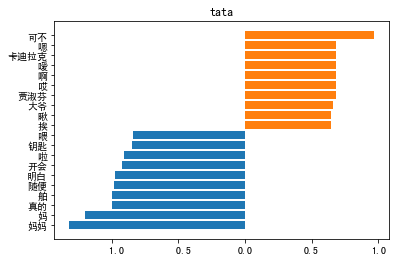

In [120]:
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.barh([item[0] for item in bottom_n],[item[1] for item in bottom_n])
plt.barh([item[0] for item in top_n],[item[1] for item in top_n])
print(plt.title("tata"))

In [128]:
def get_top_features(n,i,coef_df,feature_names,label):
    
    plt.rcParams['font.sans-serif'] = ['SimHei']

    full_array = coef_df.iloc[i,]
    top_n = sorted(sorted(list(zip(feature_names,full_array)), key=lambda x: x[1],reverse=True)[0:n],key=lambda x: x[1])
    bottom_n = sorted(list(zip(feature_names,full_array)), key=lambda x: x[1])[0:n] 

    plt.barh([item[0] for item in bottom_n],[item[1] for item in bottom_n])
    plt.barh([item[0] for item in top_n],[item[1] for item in top_n])
    print(plt.title(label))


Text(0.5, 1.0, 'children-in-law_parents-in-law vs children_parents')


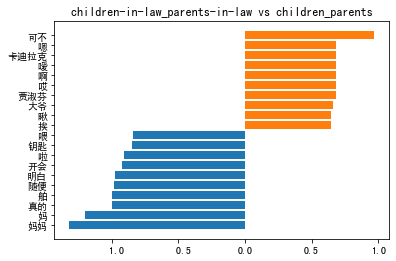

In [129]:
get_top_features(10,0,coef_df,SVM_feature_names,row_names[0])

Text(0.5, 1.0, 'children-in-law_parents-in-law vs grandchildren_grandparents')


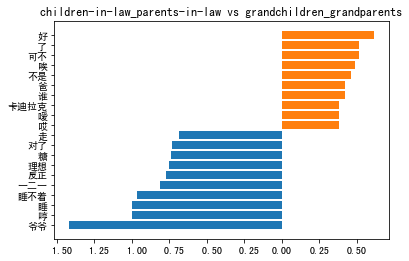

In [130]:
get_top_features(10,1,coef_df,SVM_feature_names,row_names[1])

Text(0.5, 1.0, 'children-in-law_parents-in-law vs grandparents_grandchildren')


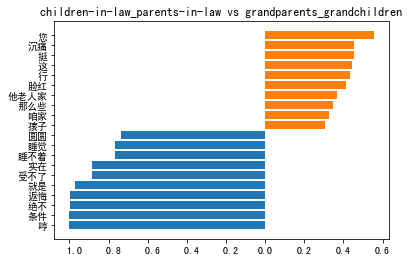

In [131]:
get_top_features(10,2,coef_df,SVM_feature_names,row_names[2])

In [134]:
#Make a dictionary of above results

top_10s = dict()
cross_cutting = dict()

for i in range(0,len(row_names)):
    
    label = row_names[i]

    full_array = coef_df.iloc[i,]
    top_n = sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1],reverse=True)[0:n]
    bottom_n = sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1])[0:n]
    
    x = label.split(' vs ')[0]
    y = label.split(' vs ')[0]
    
    top_10s[label] = dict()
    top_10s[label]['top_n'] = top_n
    top_10s[label]['bottom_n'] = bottom_n
    
    if x not in cross_cutting:
        cross_cutting[x] = []
    cross_cutting[x].append([item[0] for item in top_n])
    
    if y not in cross_cutting:
        cross_cutting[y] = []
    cross_cutting[y].append([item[0] for item in bottom_n])

In [135]:
cross_cutting['children-in-law_parents-in-law']

[['可不', '嗯', '卡迪拉克', '嗳', '啊', '哎', '贾淑芬', '大爷', '瞅', '挨'],
 ['妈妈', '妈', '真的', '舶', '随便', '明白', '开会', '啦', '钥匙', '喂'],
 ['好', '了', '可不', '唉', '不是', '爸', '谁', '卡迪拉克', '嗳', '哎'],
 ['爷爷', '哼', '睡', '睡不着', '一二一', '反正', '理想', '糖', '对了', '走'],
 ['您', '挺', '沉痛', '这', '行', '脸红', '他老人家', '那么些', '咱家', '孩子'],
 ['哼', '条件', '绝不', '返悔', '就是', '受不了', '实在', '睡不着', '睡觉', '圆圆'],
 ['您', '他老人家', '可不', '嗯', '爸', '唉', '卡迪拉克', '大爷', '脸红', '贾淑芬'],
 ['多少', '嗨', '哼', '哦', '哎呀', '作风', '坐', '干什么', '这个', '对'],
 ['您', '脸红', '叫', '沉痛', '抓', '爸', '人', '你们', '哟', '起来'],
 ['噢', '为什么', '行', '嘿', '要说', '吓死', '这个', '吨数', '呢', '是不是'],
 ['您', '脸红', '可不', '没有', '正', '一个', '他老人家', '呐', '咱家', '爸'],
 ['累', '水下', '潜艇', '别', '肥皂', '知道', '根本', '味儿', '喘气', '不吃'],
 ['您', '了', '啊', '这', '听见', '就', '该', '瞅', '他', '怎么'],
 ['换房', '骗', '算', '唔', '外头', '刘颖', '在', '不要', '大方向', '开涮'],
 ['您', '爸', '卡迪拉克', '可不', '脸红', '该', '贾淑芬', '咱家', '唉', '太'],
 ['同学', '目的', '现实', '贼胆', '回事儿', '残酷', '坏', '和平', '病源', '平易近人']]

In [132]:
test = 'children-in-law_parents-in-law vs grandparents_grandchildren'
test.split(' vs ')

['children-in-law_parents-in-law', 'grandparents_grandchildren']

In [62]:
SVM.coef_.shape

(36, 3602)

In [13]:
Counter(y_pred)

Counter({'children-in-law_parents-in-law': 30,
         'parents_children': 14,
         'parents-in-law_children-in-law': 72,
         'spouse_spouse': 100,
         'relative_relative': 5,
         'children_parents': 24,
         'grandchildren_grandparents': 11,
         'grandparents_grandchildren': 14})

In [14]:
Counter(y_test)

Counter({'children_parents': 27,
         'spouse_spouse': 86,
         'parents_children': 25,
         'parents-in-law_children-in-law': 49,
         'children-in-law_parents-in-law': 39,
         'siblings_siblings': 2,
         'grandparents_grandchildren': 20,
         'grandchildren_grandparents': 15,
         'relative_relative': 7})

In [15]:
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 270 points : 171


In [25]:
#evaluate
print(accuracy_score(y_test,y_pred))
#print(f1_score(y_test,y_pred))
confusion_matrix(y_test, y_pred) #even more the case than the Logistic Regression

0.34814814814814815


array([[17,  5,  2,  2,  7,  0,  0,  0,  6],
       [ 4,  6,  2,  1,  4,  1,  1,  1,  7],
       [ 3,  3,  4,  1,  3,  0,  0,  0,  1],
       [ 4,  1,  2,  2,  5,  3,  0,  0,  3],
       [ 3,  1,  2,  4, 21,  3,  0,  0, 15],
       [ 1,  1,  1,  2,  9,  1,  0,  0, 10],
       [ 0,  1,  0,  0,  3,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 7,  5,  4,  7, 16,  4,  1,  0, 42]])

In [37]:
resuls_cm = results(y_test,y_pred)
resuls_cm.metric()
test_cm = resuls_cm.cm
test_cm

Overall accuracy = 0.36666666666666664
children-in-law_parents-in-law: 39 total
   F1=0.4057971014492754
   Precision=0.4666666666666667
   Recall=0.358974358974359
children_parents: 27 total
   F1=0.3137254901960784
   Precision=0.3333333333333333
   Recall=0.2962962962962963
grandchildren_grandparents: 15 total
   F1=0.46153846153846156
   Precision=0.5454545454545454
   Recall=0.4
grandparents_grandchildren: 20 total
   F1=0.11764705882352941
   Precision=0.14285714285714285
   Recall=0.1
parents-in-law_children-in-law: 49 total
   F1=0.38016528925619836
   Precision=0.3194444444444444
   Recall=0.46938775510204084
parents_children: 25 total
   F1=0.05128205128205128
   Precision=0.07142857142857142
   Recall=0.04
relative_relative: 7 total
   F1=0.0
   Precision=0.0
   Recall=0.0
siblings_siblings: 2 total
   F1=0
   Precision=0
   Recall=0
spouse_spouse: 86 total
   F1=0.4838709677419355
   Precision=0.45
   Recall=0.5232558139534884


,pred,children-in-law_parents-in-law,children_parents,grandchildren_grandparents,grandparents_grandchildren,parents-in-law_children-in-law,parents_children,relative_relative,siblings_siblings,spouse_spouse
0,children-in-law_parents-in-law,14.0,2.0,3.0,2.0,2.0,1.0,1.0,0.0,5.0
1,children_parents,5.0,8.0,2.0,1.0,1.0,2.0,1.0,0.0,4.0
2,grandchildren_grandparents,2.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0
3,grandparents_grandchildren,2.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,4.0
4,parents-in-law_children-in-law,5.0,3.0,2.0,6.0,23.0,11.0,2.0,0.0,20.0
5,parents_children,1.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0,6.0
6,relative_relative,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,siblings_siblings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,spouse_spouse,8.0,9.0,2.0,7.0,17.0,7.0,3.0,2.0,45.0


Despite the poor results, there are 3 pairs that it seems to pick up on pretty well (unknown because CM isn't labelled). The others are all scattered. Note: I also didn't do any CV or anything to fine-tune feature-selection

In [42]:
#X, y = diabetes.data, diabetes.target
clf=RandomForestClassifier(n_estimators =50) #, random_state = 42, class_weight="balanced"
output = cross_validate(clf, X_train, y_train, cv=2, scoring = 'accuracy', return_estimator =True)

In [43]:
output

{'fit_time': array([0.18427181, 0.18705082]),
 'score_time': array([0.01380229, 0.01344109]),
 'estimator': [RandomForestClassifier(n_estimators=50),
  RandomForestClassifier(n_estimators=50)],
 'test_score': array([0.44981413, 0.45724907])}

In [45]:
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       #index = diabetes.feature_names,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
      importance
1704    0.037014
461     0.022532
2110    0.015081
3290    0.014815
2480    0.013002
...          ...
1590    0.000000
1592    0.000000
1593    0.000000
1595    0.000000
3601    0.000000

[3602 rows x 1 columns]
Features sorted by their score for estimator 1:
      importance
461     0.027471
1704    0.025952
1762    0.019465
2587    0.010419
2480    0.010198
...          ...
1614    0.000000
1615    0.000000
1616    0.000000
1617    0.000000
3601    0.000000

[3602 rows x 1 columns]


### Question 2
How well can a baseline model do on the actual shared task, using fasttext embeddings instead of CountVectorizer and a SVM linear classifier?

In [10]:
train_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '志国', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 2', 'y': '志国', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 3', 'y': 'S 1', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 3', 'y': 'S 2', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 3', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 3', 'y': '志国', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 4', 'y': 'S 1', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 2', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 3', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': '志国', 'r': ['unanswerable'], 'ri

**Rules for finding the relevant training data for a relation**:
- retrieve lines from speaker and from addressee
- if y is a character, retrieve lines from speaker and lines with character mentionned
- character mentions seem pretty unlikely to co-occur from the actual speaker themselves

None of these predictions are independent of each other. If I predict S1 child of S2, then S2 has to be parent of S1. If I predict S1 alternate name X, the X is also child of S2. I think I need to learn joint prediction models somehow. Joint inference? Viterbi algorithm? 

In [40]:
retrieve_mentions('志国',train_df[0][2])

[('S 1', '哟 ， 志国 回来 啦'),
 ('S 3', '这个 志国 回来 啦'),
 ('S 3', '有 什么 好 归置 的 ？ 啊 ？ 就让 它 乱 着 吧 ， 这些 破烂 我 也 不 打算 要 了 ， 志国')]

In [36]:
train_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '志国', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 2', 'y': '志国', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 3', 'y': 'S 1', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 3', 'y': 'S 2', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 3', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 3', 'y': '志国', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 4', 'y': 'S 1', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 2', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 3', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': '志国', 'r': ['unanswerable'], 'ri

In [14]:
train_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 1', 'y': 'S 3', 'r': ['per:children-in-law'], 'rid': [16]},
 {'x': 'S 1', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1', 'y': '志国', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:spouse'], 'rid': [23]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 2', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 2', 'y': '志国', 'r': ['per:alternate_name'], 'rid': [0]},
 {'x': 'S 3', 'y': 'S 1', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 3', 'y': 'S 2', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 3', 'y': 'S 4', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 3', 'y': '志国', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 4', 'y': 'S 1', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 2', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': 'S 3', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 4', 'y': '志国', 'r': ['unanswerable'], 'ri

Actually first start with my own partition because it's set up.

Training links: <br/>
[train_supervised parameters](https://fasttext.cc/docs/en/python-module.html)

In [16]:
help(ft.get_sentence_vector)

Help on method get_sentence_vector in module fasttext.FastText:

get_sentence_vector(text) method of fasttext.FastText._FastText instance
    Given a string, get a single vector represenation. This function
    assumes to be given a single line of text. We split words on
    whitespace (space, newline, tab, vertical tab) and the control
    characters carriage return, formfeed and the null character.



In [18]:
ft.get_sentence_vector(train_df[0][0][0])

array([ 1.97993517e-02, -5.67923635e-02,  1.63474202e-01,  9.01721939e-02,
        3.19148824e-02,  7.40451887e-02, -5.59923016e-02, -4.94981855e-02,
       -1.14988983e-02,  6.69984613e-03,  2.19345912e-02, -6.52322918e-03,
        3.92103456e-02,  7.74987042e-04, -2.25003064e-02,  9.03124660e-02,
        7.26490766e-02, -3.12981196e-02,  3.88168097e-02, -9.45579261e-03,
        2.03982349e-02, -3.16782780e-02, -2.34110635e-02, -1.85007099e-02,
        6.67112917e-02,  1.58710703e-02,  1.52449589e-02, -2.24385653e-02,
        2.27755457e-02,  5.18159233e-02,  1.70826949e-02, -2.06123665e-03,
       -6.62850402e-03,  5.72325662e-05, -6.87277736e-03,  4.49230373e-02,
       -4.27571833e-02, -4.46582735e-02, -2.49844007e-02, -3.69873829e-03,
        3.34399231e-02,  1.82844233e-02,  2.11279728e-02,  1.83091988e-03,
       -3.46763339e-03,  3.51379253e-02, -4.53777611e-02,  1.53266434e-02,
       -7.81879760e-04, -5.64751774e-02, -3.09978500e-02,  3.27530541e-02,
       -4.27101851e-02,  

In [11]:
%ls ../CRECIL/Orginal_data/

My_home.json  relation/


In [49]:
" ".join(list(jieba.cut((train_df[0][0][0]))))

'S   1 :   哟 ， 志国 回来 啦'

In [8]:
for ep in train_df:
    
    space_separated = []
    for line in ep[0]:
        zh = re.findall('(?<=: ).*',line)[0]
        speaker = re.findall('S [0-9]{1,2}',line)[0]
        spaced = " ".join(list(jieba.cut((zh))))
        
        space_separated.append((speaker,spaced))
    ep.append(space_separated)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.462 seconds.
Prefix dict has been built successfully.


In [5]:
for ep in dev_df:
    
    space_separated = []
    for line in ep[0]:
        zh = re.findall('(?<=: ).*',line)[0]
        speaker = re.findall('S [0-9]{1,2}',line)[0]
        spaced = " ".join(list(jieba.cut((zh))))
        
        space_separated.append((speaker,spaced))
    ep.append(space_separated)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.482 seconds.
Prefix dict has been built successfully.


In [6]:
for ep in test_df:
    
    space_separated = []
    for line in ep[0]:
        zh = re.findall('(?<=: ).*',line)[0]
        speaker = re.findall('S [0-9]{1,2}',line)[0]
        spaced = " ".join(list(jieba.cut((zh))))
        
        space_separated.append((speaker,spaced))
    ep.append(space_separated)

In [7]:
ft.get_sentence_vector(train_df[0][2][0]).size

AttributeError: 'tuple' object has no attribute 'find'

Step 3: Make a CRF <br/>
- start with a model that embeds avg sentences of speakers and addressee, and concats two averages together, prepare a bit for possible disappointing results
- concats rather than adds, because speaker and addressee are different

In [15]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

CPU times: user 26 µs, sys: 14 µs, total: 40 µs
Wall time: 42 µs


In [8]:
sentembedding = ft.get_sentence_vector(train_df[0][0][0])
features = {}
for iv,value in enumerate(sentembedding):
    features['v{}'.format(iv)]=value

In [21]:
get_avg_embeddings(retrieve_s_lines('S 1',train_df[0][2]))

{'v0': 0.01106627,
 'v1': 0.027206058,
 'v2': 0.19847792,
 'v3': 0.0024579961,
 'v4': -0.023818873,
 'v5': 0.015646469,
 'v6': -0.00043350353,
 'v7': -0.003766069,
 'v8': 0.051558167,
 'v9': -0.0015952874,
 'v10': 0.0061212024,
 'v11': -0.009077391,
 'v12': 0.022217534,
 'v13': 0.022401534,
 'v14': 0.012786963,
 'v15': 0.0058338256,
 'v16': 0.0064654355,
 'v17': -0.02994701,
 'v18': -0.038112,
 'v19': 0.0070583285,
 'v20': 0.007241482,
 'v21': 0.01436195,
 'v22': -0.030545846,
 'v23': 0.018104177,
 'v24': 0.017776167,
 'v25': 0.021293368,
 'v26': 0.04400748,
 'v27': 0.004081951,
 'v28': 0.0036035774,
 'v29': -0.0031443946,
 'v30': -0.010697305,
 'v31': -0.0389605,
 'v32': -0.009899231,
 'v33': -0.019908195,
 'v34': -0.0007293793,
 'v35': 0.0044721947,
 'v36': 0.024639366,
 'v37': -0.10570488,
 'v38': 0.01728139,
 'v39': -0.018320313,
 'v40': -0.030422416,
 'v41': -0.014750596,
 'v42': 0.053793084,
 'v43': 0.051949926,
 'v44': 0.010822419,
 'v45': -0.045076042,
 'v46': 0.04065757,
 'v47

In [47]:
# create train data for CRF
X_train = []
y_train = []
X_train_array = []
y_train_flat = []

for i in tqdm(range(0,len(train_df))): #20
    
    #list of tuples containing speakers and tokenized sentences
    dialog = train_df[i][2]
    
    #get relations and labels:
    for j in range(0,len(train_df[i][1])):
        
        rel_triplet = train_df[i][1][j]
        x = rel_triplet['x']
        y = rel_triplet['y']
        r = rel_triplet['r'] #note that this is a list that can have len>1
        
        for rel in r:
            y_train.append([rel])
            y_train_flat.append(rel)
            
            # retrieve lines by speakers or entity mentionned:
            if bool(re.search('S',x)):
                x_lines = retrieve_s_lines(x,dialog)
            else:
                x_lines = retrieve_mentions(x,dialog)

            if bool(re.search('S',y)):
                y_lines = retrieve_s_lines(y,dialog)
            else:
                y_lines = retrieve_mentions(y,dialog)
            
            # Get the average embeddings of the lines
            if len(x_lines)>0:
                x_embed = get_avg_embeddings(x_lines)
            else:  #note: there could be no lines from the speaker or entity, (did not talk)
                x_embed = np.zeros(100)
            if len(y_lines)>0:
                y_embed = get_avg_embeddings(y_lines)
            else:
                y_embed = np.zeros(100)
            
            x_y_embed = np.concatenate((x_embed,y_embed)) # 1x600 np array 
            
            X_train.append([embeddings_to_features(x_y_embed)])
            X_train_array.append(x_y_embed)

100%|██████████| 482/482 [00:07<00:00, 66.58it/s]


In [48]:
# create dev data for CRF
X_dev = []
y_dev = []
X_dev_array = []
y_dev_flat = []

for i in tqdm(range(0,len(dev_df))): #20
    
    #list of tuples containing speakers and tokenized sentences
    dialog = dev_df[i][2]
    
    #get relations and labels:
    for j in range(0,len(dev_df[i][1])):
        
        rel_triplet = dev_df[i][1][j]
        x = rel_triplet['x']
        y = rel_triplet['y']
        r = rel_triplet['r'] #note that this is a list that can have len>1
        
        for rel in r:
            y_dev.append([rel])
            y_dev_flat.append(rel)
            
            # retrieve lines by speakers or entity mentionned:
            if bool(re.search('S',x)):
                x_lines = retrieve_s_lines(x,dialog)
            else:
                x_lines = retrieve_mentions(x,dialog)

            if bool(re.search('S',y)):
                y_lines = retrieve_s_lines(y,dialog)
            else:
                y_lines = retrieve_mentions(y,dialog)
            
            # Get the average embeddings of the lines
            if len(x_lines)>0:
                x_embed = get_avg_embeddings(x_lines)
            else:  #note: there could be no lines from the speaker or entity, (did not talk)
                x_embed = np.zeros(100)
            if len(y_lines)>0:
                y_embed = get_avg_embeddings(y_lines)
            else:
                y_embed = np.zeros(100)
            
            x_y_embed = np.concatenate((x_embed,y_embed)) # 1x600 np array 
            
            X_dev.append([embeddings_to_features(x_y_embed)])
            X_dev_array.append(x_y_embed)

100%|██████████| 116/116 [00:01<00:00, 80.68it/s]


In [49]:
# create test data for CRF
X_test = []
y_test = []
X_test_array = []
y_test_flat = []


for i in tqdm(range(0,len(test_df))): #20
    
    #list of tuples containing speakers and tokenized sentences
    dialog = test_df[i][2]
    
    #get relations and labels:
    for j in range(0,len(test_df[i][1])):
        
        rel_triplet = test_df[i][1][j]
        x = rel_triplet['x']
        y = rel_triplet['y']
        r = rel_triplet['r'] #note that this is a list that can have len>1
        
        for rel in r:
            y_test.append([rel])
            y_test_flat.append(rel)
            
            # retrieve lines by speakers or entity mentionned:
            if bool(re.search('S',x)):
                x_lines = retrieve_s_lines(x,dialog)
            else:
                x_lines = retrieve_mentions(x,dialog)

            if bool(re.search('S',y)):
                y_lines = retrieve_s_lines(y,dialog)
            else:
                y_lines = retrieve_mentions(y,dialog)
            
            # Get the average embeddings of the lines
            if len(x_lines)>0:
                x_embed = get_avg_embeddings(x_lines)
            else:  #note: there could be no lines from the speaker or entity, (did not talk)
                x_embed = np.zeros(100)
            if len(y_lines)>0:
                y_embed = get_avg_embeddings(y_lines)
            else:
                y_embed = np.zeros(100)
            
            x_y_embed = np.concatenate((x_embed,y_embed)) # 1x600 np array 
            
            X_test.append([embeddings_to_features(x_y_embed)])
            X_test_array.append(x_y_embed)

100%|██████████| 71/71 [00:00<00:00, 76.09it/s] 


In [50]:
crf.fit(X_train, y_train)

/home2/elyeb/anaconda3/envs/python368env/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [51]:
y_dev_predict = crf.predict(X_dev)

In [52]:
y_test_predict = crf.predict(X_test)

In [53]:
labels = list(crf.classes_)
metrics.flat_f1_score(y_test, y_test_predict,
                      average='weighted', labels=labels)

/home2/elyeb/anaconda3/envs/python368env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.18733202933298904

In [54]:
labels = list(crf.classes_)
metrics.flat_f1_score(y_dev, y_dev_predict,
                      average='weighted', labels=labels)

0.16068029756658578

In [27]:
y_train_predict = crf.predict(X_train)

In [28]:
metrics.flat_f1_score(y_train, y_train_predict,
                      average='weighted', labels=labels)

0.17828860143311312

In [55]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_test_predict, labels=sorted_labels, digits=3
))

                         precision    recall  f1-score   support

       per:acquaintance      0.000     0.000     0.000       181
     per:alternate_name      0.092     0.031     0.046       547
               per:boss      0.000     0.000     0.000        78
          per:boyfriend      0.000     0.000     0.000        46
           per:children      0.168     0.057     0.085       335
    per:children-in-law      0.000     0.000     0.000        86
          per:classmate      0.000     0.000     0.000        34
             per:client      0.000     0.000     0.000        19
          per:colleague      0.000     0.000     0.000        30
              per:dates      0.000     0.000     0.000        28
       per:ex-boyfriend      0.000     0.000     0.000        22
      per:ex-girlfriend      0.000     0.000     0.000        22
            per:friends      0.300     0.014     0.026       218
         per:girlfriend      0.000     0.000     0.000        46
      per:grandchildren 

/home2/elyeb/anaconda3/envs/python368env/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['per:acquaintance', 'per:alternate_name', 'per:boss', 'per:boyfriend', 'per:children', 'per:children-in-law', 'per:classmate', 'per:client', 'per:colleague', 'per:dates', 'per:ex-boyfriend', 'per:ex-girlfriend', 'per:friends', 'per:girlfriend', 'per:grandchildren', 'per:grandparents', 'per:negative impression', 'per:neighbor', 'per:nickname', 'per:nurse', 'per:parents', 'per:parents-in-law', 'per:positive impression', 'per:relative', 'per:roommate', 'per:siblings', 'per:siblings-in-law', 'per:spouse', 'per:student', 'per:subordinate', 'per:teacher', 'unanswerable'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home2/elyeb/anaconda3/envs/python368env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

In [58]:
#fit
#X_train_array = pd.DataFrame(X_train_array)
SVM = SVC(kernel = 'linear')
SVM.fit(X_train_array,y_train_flat)
#y_pred=SVM.predict(X_dev)
y_pred=SVM.predict(X_test_array)

SVC(kernel='linear')

In [59]:
X_dev_array = pd.DataFrame(X_dev_array)
X_test_array = pd.DataFrame(X_test_array)

In [60]:
y_pred=SVM.predict(X_test_array)

In [71]:
y_test_unlist = [item[0] for item in y_test]

In [79]:
Counter(y_pred)

Counter({'unanswerable': 5395})

In [57]:
X_train_array.shape

(38684, 200)

In [61]:
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

ValueError: Found input variables with inconsistent numbers of samples: [5395, 64740]

Testing full (actually only pairwise, but still better than sequence) CRF: pystruct

In [28]:
import pystruct

In [29]:
import sklearn.externals as extjoblib
from pystruct import models

ModuleNotFoundError: No module named 'sklearn.externals.joblib'

In [27]:
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

NameError: name 'sys' is not defined

In [23]:
import sklearn
sklearn.externals.joblib = joblib

In [25]:
import pkg_resources
from subprocess import call

packages = [dist.project_name for dist in pkg_resources.working_set]
call("pip3 install --upgrade " + ' '.join(packages), shell=True)


1

In [26]:
from pystruct.models import GraphCRF


ModuleNotFoundError: No module named 'sklearn.externals.joblib'

In [ ]:
dir(GraphCRF)

TRYING TF-IDF

In [4]:
# Task 1: predict subset of relation pairs over balanced data
with open('ref_files/id_label.pickle','rb') as infile:
    id_label = pickle.load(infile)

with open('ref_files/label_id.pickle','rb') as infile:
    label_id = pickle.load(infile)

**Reorganized labels**
Mirrored relations (11):
- per:friends, per:friends
- per:spouse, per:spouse
- per:classmate, per:classmate
- per:neighbor, per:neighbor
- per:acquaintance, per:acquaintance
- per:dates, per:dates
- per:relative, per:relative
- per:siblings, per:siblings
- per:colleague, per:colleague
- per:siblings-in-law, per:siblings-in-law
- per:roommate, per:roommate


Unmirrored relations (9):
- per:children-in-law, per:parents-in-law
- per:children, per:parents
- per:grandchildren, per:grandparents
- per:ex-girlfriend, per:ex-boyfriend
- per:girlfriend, per:boyfriend
- per:subordinate, per:boss
- per:student, per:teacher
- unanswerable, unanswerable
- per:alternate_name, per:alternate_name

Other (7):
- per:nurse
- per:negative impression
- per:positive impression
- per:client
- per:nickname

In [5]:
grp_rels = dict()
y_train = dict()

y_train['per:friends-per:friends']=dict()
y_train['per:friends-per:friends']['col_num'] = 0
y_train['per:friends-per:friends']['y'] = []
y_train['per:friends-per:friends']['y_index'] = []

y_train['per:spouse-per:spouse']=dict()
y_train['per:spouse-per:spouse']['col_num'] =1
y_train['per:spouse-per:spouse']['y'] = []
y_train['per:spouse-per:spouse']['y_index'] = []

y_train['per:classmate-per:classmate']=dict()
y_train['per:classmate-per:classmate']['col_num'] =2
y_train['per:classmate-per:classmate']['y'] = []
y_train['per:classmate-per:classmate']['y_index'] = []

y_train['per:neighbor-per:neighbor']=dict()
y_train['per:neighbor-per:neighbor']['col_num'] =3
y_train['per:neighbor-per:neighbor']['y'] = []
y_train['per:neighbor-per:neighbor']['y_index'] = []

y_train['per:acquaintance-per:acquaintance']=dict()
y_train['per:acquaintance-per:acquaintance']['col_num'] =4
y_train['per:acquaintance-per:acquaintance']['y'] = []
y_train['per:acquaintance-per:acquaintance']['y_index'] = []

y_train['per:dates-per:dates']=dict()
y_train['per:dates-per:dates']['col_num'] =5
y_train['per:dates-per:dates']['y'] = []
y_train['per:dates-per:dates']['y_index'] = []

y_train['per:relative-per:relative']=dict()
y_train['per:relative-per:relative']['col_num'] =6
y_train['per:relative-per:relative']['y'] = []
y_train['per:relative-per:relative']['y_index'] = []

y_train['per:siblings-per:siblings']=dict()
y_train['per:siblings-per:siblings']['col_num'] =7
y_train['per:siblings-per:siblings']['y'] = []
y_train['per:siblings-per:siblings']['y_index'] = []

y_train['per:colleague-per:colleague']=dict()
y_train['per:colleague-per:colleague']['col_num'] =8
y_train['per:colleague-per:colleague']['y'] = []
y_train['per:colleague-per:colleague']['y_index'] = []

y_train['per:siblings-in-law-per:siblings-in-law']=dict()
y_train['per:siblings-in-law-per:siblings-in-law']['col_num']=9
y_train['per:siblings-in-law-per:siblings-in-law']['y'] = []
y_train['per:siblings-in-law-per:siblings-in-law']['y_index'] = []

y_train['per:roommate-per:per:roommate']=dict()
y_train['per:roommate-per:per:roommate']['col_num'] =10
y_train['per:roommate-per:per:roommate']['y'] = []
y_train['per:roommate-per:per:roommate']['y_index'] = []

y_train['unanswerable-unanswerable']=dict()
y_train['unanswerable-unanswerable']['col_num'] = 11
y_train['unanswerable-unanswerable']['y'] = []
y_train['unanswerable-unanswerable']['y_index'] = []

y_train['per:alternate_name:per:alternate_name']=dict()
y_train['per:alternate_name:per:alternate_name']['col_num'] = 12
y_train['per:alternate_name:per:alternate_name']['y'] = []
y_train['per:alternate_name:per:alternate_name']['y_index'] = []

y_train['per:children-in-law-per:parents-in-law']=dict()
y_train['per:children-in-law-per:parents-in-law']['col_num'] = 13
y_train['per:children-in-law-per:parents-in-law']['y'] = []
y_train['per:children-in-law-per:parents-in-law']['y_index'] = []

y_train['per:children-per:parents']=dict()
y_train['per:children-per:parents']['col_num'] = 14
y_train['per:children-per:parents']['y'] = []
y_train['per:children-per:parents']['y_index'] = []

y_train['per:grandchildren-per:grandparents']=dict()
y_train['per:grandchildren-per:grandparents']['col_num'] = 15
y_train['per:grandchildren-per:grandparents']['y'] = []
y_train['per:grandchildren-per:grandparents']['y_index'] = []

y_train['per:ex-girlfriend-per:ex-boyfriend']=dict()
y_train['per:ex-girlfriend-per:ex-boyfriend']['col_num'] = 16
y_train['per:ex-girlfriend-per:ex-boyfriend']['y'] = []
y_train['per:ex-girlfriend-per:ex-boyfriend']['y_index'] = []

y_train['per:girlfriend-per:boyfriend']=dict()
y_train['per:girlfriend-per:boyfriend']['col_num'] = 17
y_train['per:girlfriend-per:boyfriend']['y'] = []
y_train['per:girlfriend-per:boyfriend']['y_index'] = []

y_train['per:subordinate-per:boss']=dict()
y_train['per:subordinate-per:boss']['col_num'] = 18
y_train['per:subordinate-per:boss']['y'] = []
y_train['per:subordinate-per:boss']['y_index'] = []

y_train['per:student-per:teacher']=dict()
y_train['per:student-per:teacher']['col_num'] = 19
y_train['per:student-per:teacher']['y'] = []
y_train['per:student-per:teacher']['y_index'] = []

y_train['per:nurse']=dict()
y_train['per:nurse']['col_num'] = 20
y_train['per:nurse']['y'] = []
y_train['per:nurse']['y_index'] = []

y_train['per:negative impression']=dict()
y_train['per:negative impression']['col_num'] = 21
y_train['per:negative impression']['y'] = []
y_train['per:negative impression']['y_index'] = []

y_train['per:positive impression']=dict()
y_train['per:positive impression']['col_num'] = 22
y_train['per:positive impression']['y'] = []
y_train['per:positive impression']['y_index'] = []

y_train['per:client']=dict()
y_train['per:client']['col_num'] = 23
y_train['per:client']['y'] = []
y_train['per:client']['y_index'] = []

y_train['per:nickname']=dict()
y_train['per:nickname']['col_num'] = 24
y_train['per:nickname']['y'] = []
y_train['per:nickname']['y_index'] = []

grp_rels['per:friends'] = dict()
grp_rels['per:friends']['set'] = ['per:friends', 'per:friends']
grp_rels['per:friends']['group'] = 'per:friends-per:friends'
grp_rels['per:friends']['col_num'] = 0

grp_rels['per:spouse'] = dict()
grp_rels['per:spouse']['set'] = ['per:spouse', 'per:spouse']
grp_rels['per:spouse']['group'] = 'per:spouse-per:spouse'
grp_rels['per:spouse']['col_num'] = 1

grp_rels['per:classmate'] = dict()
grp_rels['per:classmate']['set'] = ['per:classmate', 'per:classmate']
grp_rels['per:classmate']['group'] = 'per:classmate-per:classmate'
grp_rels['per:classmate']['col_num'] = 2

grp_rels['per:neighbor'] = dict()
grp_rels['per:neighbor']['set'] = ['per:neighbor', 'per:neighbor']
grp_rels['per:neighbor']['group'] = 'per:neighbor-per:neighbor'
grp_rels['per:neighbor']['col_num'] = 3

grp_rels['per:acquaintance'] = dict()
grp_rels['per:acquaintance']['set'] = ['per:acquaintance', 'per:acquaintance']
grp_rels['per:acquaintance']['group'] = 'per:acquaintance-per:acquaintance'
grp_rels['per:acquaintance']['col_num'] = 4

grp_rels['per:dates'] = dict()
grp_rels['per:dates']['set'] = ['per:dates', 'per:dates']
grp_rels['per:dates']['group'] = 'per:dates-per:dates'
grp_rels['per:dates']['col_num'] = 5

grp_rels['per:relative'] = dict()
grp_rels['per:relative']['set'] = ['per:relative', 'per:relative']
grp_rels['per:relative']['group'] = 'per:relative-per:relative'
grp_rels['per:relative']['col_num'] = 6

grp_rels['per:siblings'] = dict()
grp_rels['per:siblings']['set'] = ['per:siblings', 'per:siblings']
grp_rels['per:siblings']['group'] = 'per:siblings-per:siblings'
grp_rels['per:siblings']['col_num'] = 7

grp_rels['per:colleague'] = dict()
grp_rels['per:colleague']['set'] = ['per:colleague', 'per:colleague']
grp_rels['per:colleague']['group'] = 'per:colleague-per:colleague'
grp_rels['per:colleague']['col_num'] = 8

grp_rels['per:siblings-in-law'] = dict()
grp_rels['per:siblings-in-law']['set'] = ['per:siblings-in-law', 'per:siblings-in-law']
grp_rels['per:siblings-in-law']['group'] = 'per:siblings-in-law-per:siblings-in-law'
grp_rels['per:siblings-in-law']['col_num'] = 9

grp_rels['per:roommate'] = dict()
grp_rels['per:roommate']['set'] = ['per:roommate', 'per:roommate']
grp_rels['per:roommate']['group'] = 'per:roommate-per:per:roommate'
grp_rels['per:roommate']['col_num'] = 10

grp_rels['unanswerable'] = dict()
grp_rels['unanswerable']['set'] = ['unanswerable', 'unanswerable']
grp_rels['unanswerable']['group'] = 'unanswerable-unanswerable'
grp_rels['unanswerable']['col_num'] = 11

grp_rels['per:alternate_name'] = dict()
grp_rels['per:alternate_name']['set'] = ['per:alternate_name', 'per:alternate_name']
grp_rels['per:alternate_name']['group'] = 'per:alternate_name:per:alternate_name'
grp_rels['per:alternate_name']['col_num'] = 12

grp_rels['per:parents-in-law'] = dict()
grp_rels['per:parents-in-law']['set'] = ['per:children-in-law', 'per:parents-in-law']
grp_rels['per:parents-in-law']['group'] = 'per:children-in-law-per:parents-in-law'
grp_rels['per:parents-in-law']['col_num'] = 13

grp_rels['per:children-in-law'] = dict()
grp_rels['per:children-in-law']['set'] = ['per:children-in-law', 'per:parents-in-law']
grp_rels['per:children-in-law']['group'] = 'per:children-in-law-per:parents-in-law'
grp_rels['per:children-in-law']['col_num'] = 13

grp_rels['per:parents'] = dict()
grp_rels['per:parents']['set'] = ['per:children', 'per:parents']
grp_rels['per:parents']['group'] = 'per:children-per:parents'
grp_rels['per:parents']['col_num'] = 14

grp_rels['per:children'] = dict()
grp_rels['per:children']['set'] = ['per:children', 'per:parents']
grp_rels['per:children']['group'] = 'per:children-per:parents'
grp_rels['per:children']['col_num'] = 14

grp_rels['per:grandparents'] = dict()
grp_rels['per:grandparents']['set'] = ['per:grandchildren', 'per:grandparents']
grp_rels['per:grandparents']['group'] = 'per:grandchildren-per:grandparents'
grp_rels['per:grandparents']['col_num'] = 15

grp_rels['per:grandchildren'] = dict()
grp_rels['per:grandchildren']['set'] = ['per:grandchildren', 'per:grandparents']
grp_rels['per:grandchildren']['group'] = 'per:grandchildren-per:grandparents'
grp_rels['per:grandchildren']['col_num'] = 15

grp_rels['per:ex-boyfriend'] = dict()
grp_rels['per:ex-boyfriend']['set'] = ['per:ex-girlfriend', 'per:ex-boyfriend']
grp_rels['per:ex-boyfriend']['group'] = 'per:ex-girlfriend-per:ex-boyfriend'
grp_rels['per:ex-boyfriend']['col_num'] = 16

grp_rels['per:ex-girlfriend'] = dict()
grp_rels['per:ex-girlfriend']['set'] = ['per:ex-girlfriend', 'per:ex-boyfriend']
grp_rels['per:ex-girlfriend']['group'] = 'per:ex-girlfriend-per:ex-boyfriend'
grp_rels['per:ex-girlfriend']['col_num'] = 16

grp_rels['per:boyfriend'] = dict()
grp_rels['per:boyfriend']['set'] = ['per:girlfriend', 'per:boyfriend']
grp_rels['per:boyfriend']['group'] = 'per:girlfriend-per:boyfriend'
grp_rels['per:boyfriend']['col_num'] = 17

grp_rels['per:girlfriend'] = dict()
grp_rels['per:girlfriend']['set'] = ['per:girlfriend', 'per:boyfriend']
grp_rels['per:girlfriend']['group'] = 'per:girlfriend-per:boyfriend'
grp_rels['per:girlfriend']['col_num'] = 17

grp_rels['per:boss'] = dict()
grp_rels['per:boss']['set'] = ['per:subordinate', 'per:boss']
grp_rels['per:boss']['group'] = 'per:subordinate-per:boss'
grp_rels['per:boss']['col_num'] = 18

grp_rels['per:subordinate'] = dict()
grp_rels['per:subordinate']['set'] = ['per:subordinate', 'per:boss']
grp_rels['per:subordinate']['group'] = 'per:subordinate-per:boss'
grp_rels['per:subordinate']['col_num'] = 18

grp_rels['per:teacher'] = dict()
grp_rels['per:teacher']['set'] = ['per:student', 'per:teacher']
grp_rels['per:teacher']['group'] = 'per:student-per:teacher'
grp_rels['per:teacher']['col_num'] = 19

grp_rels['per:student'] = dict()
grp_rels['per:student']['set'] = ['per:student', 'per:teacher']
grp_rels['per:student']['group'] = 'per:student-per:teacher'
grp_rels['per:student']['col_num'] = 19

grp_rels['per:nurse'] = dict()
grp_rels['per:nurse']['set'] = ['per:nurse']
grp_rels['per:nurse']['group'] = 'per:nurse'
grp_rels['per:nurse']['col_num'] = 20

grp_rels['per:negative impression'] = dict()
grp_rels['per:negative impression']['set'] = ['per:negative impression']
grp_rels['per:negative impression']['group'] = 'per:negative impression'
grp_rels['per:negative impression']['col_num'] = 21

grp_rels['per:positive impression'] = dict()
grp_rels['per:positive impression']['set'] = ['per:positive impression']
grp_rels['per:positive impression']['group'] = 'per:positive impression'
grp_rels['per:positive impression']['col_num'] = 22

grp_rels['per:client'] = dict()
grp_rels['per:client']['set'] = ['per:client']
grp_rels['per:client']['group'] = 'per:client'
grp_rels['per:client']['col_num'] = 23

grp_rels['per:nickname'] = dict()
grp_rels['per:nickname']['set'] = ['per:nickname']
grp_rels['per:nickname']['group'] = 'per:nickname'
grp_rels['per:nickname']['col_num'] = 24


In [6]:
y_dev = dict()

y_dev['per:friends-per:friends']=dict()
y_dev['per:friends-per:friends']['col_num'] = 0
y_dev['per:friends-per:friends']['y'] = []
y_dev['per:friends-per:friends']['y_index'] = []

y_dev['per:spouse-per:spouse']=dict()
y_dev['per:spouse-per:spouse']['col_num'] =1
y_dev['per:spouse-per:spouse']['y'] = []
y_dev['per:spouse-per:spouse']['y_index'] = []

y_dev['per:classmate-per:classmate']=dict()
y_dev['per:classmate-per:classmate']['col_num'] =2
y_dev['per:classmate-per:classmate']['y'] = []
y_dev['per:classmate-per:classmate']['y_index'] = []

y_dev['per:neighbor-per:neighbor']=dict()
y_dev['per:neighbor-per:neighbor']['col_num'] =3
y_dev['per:neighbor-per:neighbor']['y'] = []
y_dev['per:neighbor-per:neighbor']['y_index'] = []

y_dev['per:acquaintance-per:acquaintance']=dict()
y_dev['per:acquaintance-per:acquaintance']['col_num'] =4
y_dev['per:acquaintance-per:acquaintance']['y'] = []
y_dev['per:acquaintance-per:acquaintance']['y_index'] = []

y_dev['per:dates-per:dates']=dict()
y_dev['per:dates-per:dates']['col_num'] =5
y_dev['per:dates-per:dates']['y'] = []
y_dev['per:dates-per:dates']['y_index'] = []

y_dev['per:relative-per:relative']=dict()
y_dev['per:relative-per:relative']['col_num'] =6
y_dev['per:relative-per:relative']['y'] = []
y_dev['per:relative-per:relative']['y_index'] = []

y_dev['per:siblings-per:siblings']=dict()
y_dev['per:siblings-per:siblings']['col_num'] =7
y_dev['per:siblings-per:siblings']['y'] = []
y_dev['per:siblings-per:siblings']['y_index'] = []

y_dev['per:colleague-per:colleague']=dict()
y_dev['per:colleague-per:colleague']['col_num'] =8
y_dev['per:colleague-per:colleague']['y'] = []
y_dev['per:colleague-per:colleague']['y_index'] = []

y_dev['per:siblings-in-law-per:siblings-in-law']=dict()
y_dev['per:siblings-in-law-per:siblings-in-law']['col_num']=9
y_dev['per:siblings-in-law-per:siblings-in-law']['y'] = []
y_dev['per:siblings-in-law-per:siblings-in-law']['y_index'] = []

y_dev['per:roommate-per:per:roommate']=dict()
y_dev['per:roommate-per:per:roommate']['col_num'] =10
y_dev['per:roommate-per:per:roommate']['y'] = []
y_dev['per:roommate-per:per:roommate']['y_index'] = []

y_dev['unanswerable-unanswerable']=dict()
y_dev['unanswerable-unanswerable']['col_num'] = 11
y_dev['unanswerable-unanswerable']['y'] = []
y_dev['unanswerable-unanswerable']['y_index'] = []

y_dev['per:alternate_name:per:alternate_name']=dict()
y_dev['per:alternate_name:per:alternate_name']['col_num'] = 12
y_dev['per:alternate_name:per:alternate_name']['y'] = []
y_dev['per:alternate_name:per:alternate_name']['y_index'] = []

y_dev['per:children-in-law-per:parents-in-law']=dict()
y_dev['per:children-in-law-per:parents-in-law']['col_num'] = 13
y_dev['per:children-in-law-per:parents-in-law']['y'] = []
y_dev['per:children-in-law-per:parents-in-law']['y_index'] = []

y_dev['per:children-per:parents']=dict()
y_dev['per:children-per:parents']['col_num'] = 14
y_dev['per:children-per:parents']['y'] = []
y_dev['per:children-per:parents']['y_index'] = []

y_dev['per:grandchildren-per:grandparents']=dict()
y_dev['per:grandchildren-per:grandparents']['col_num'] = 15
y_dev['per:grandchildren-per:grandparents']['y'] = []
y_dev['per:grandchildren-per:grandparents']['y_index'] = []

y_dev['per:ex-girlfriend-per:ex-boyfriend']=dict()
y_dev['per:ex-girlfriend-per:ex-boyfriend']['col_num'] = 16
y_dev['per:ex-girlfriend-per:ex-boyfriend']['y'] = []
y_dev['per:ex-girlfriend-per:ex-boyfriend']['y_index'] = []

y_dev['per:girlfriend-per:boyfriend']=dict()
y_dev['per:girlfriend-per:boyfriend']['col_num'] = 17
y_dev['per:girlfriend-per:boyfriend']['y'] = []
y_dev['per:girlfriend-per:boyfriend']['y_index'] = []

y_dev['per:subordinate-per:boss']=dict()
y_dev['per:subordinate-per:boss']['col_num'] = 18
y_dev['per:subordinate-per:boss']['y'] = []
y_dev['per:subordinate-per:boss']['y_index'] = []

y_dev['per:student-per:teacher']=dict()
y_dev['per:student-per:teacher']['col_num'] = 19
y_dev['per:student-per:teacher']['y'] = []
y_dev['per:student-per:teacher']['y_index'] = []

y_dev['per:nurse']=dict()
y_dev['per:nurse']['col_num'] = 20
y_dev['per:nurse']['y'] = []
y_dev['per:nurse']['y_index'] = []

y_dev['per:negative impression']=dict()
y_dev['per:negative impression']['col_num'] = 21
y_dev['per:negative impression']['y'] = []
y_dev['per:negative impression']['y_index'] = []

y_dev['per:positive impression']=dict()
y_dev['per:positive impression']['col_num'] = 22
y_dev['per:positive impression']['y'] = []
y_dev['per:positive impression']['y_index'] = []

y_dev['per:client']=dict()
y_dev['per:client']['col_num'] = 23
y_dev['per:client']['y'] = []
y_dev['per:client']['y_index'] = []

y_dev['per:nickname']=dict()
y_dev['per:nickname']['col_num'] = 24
y_dev['per:nickname']['y'] = []
y_dev['per:nickname']['y_index'] = []

In [7]:
all_labels = list(label_id.keys())
all_groups = [grp_rels[item]['group'] for item in grp_rels]

In [8]:
# Create lines data for train_df

X_train = []

index= 0

for i in tqdm(range(0,len(train_df))): 
    
    #list of tuples containing speakers and tokenized sentences
    dialog = train_df[i][2]
    
    #get relations and labels:
    for j in range(0,len(train_df[i][1])):
        
        rel_triplet = train_df[i][1][j]
        x = rel_triplet['x']
        y = rel_triplet['y']
        r = rel_triplet['r'] #note that this is a list that can have len>1

        # retrieve lines by speakers or entity mentionned:
        if bool(re.search('S',x)):
            x_lines = retrieve_s_lines(x,dialog)
        else:
            x_lines = retrieve_mentions(x,dialog)

        if bool(re.search('S',y)):
            y_lines = retrieve_s_lines(y,dialog)
        else:
            y_lines = retrieve_mentions(y,dialog)

        X_train.append(' '.join([line for line in x_lines])+' '.join([line for line in y_lines]))
        
        # Currently mapping to broader class group
        current_grps = []
        for rel in r:
            current_grps.append(grp_rels[rel]['group'])
        
        current_grps = list(set(current_grps))
        for rel in current_grps:
            y_train[rel]['y'].append(1)
            y_train[rel]['y_index'].append(index)
            
        counter_examples_rels = list(set(all_groups).difference(set(current_grps)))
        for rel in counter_examples_rels:
            y_train[rel]['y'].append(0) 
            y_train[rel]['y_index'].append(index)
 

100%|████████████████████████████████████████| 482/482 [00:01<00:00, 428.71it/s]


In [9]:
X_dev = []

index= 0

for i in tqdm(range(0,len(dev_df))): 
    
    #list of tuples containing speakers and tokenized sentences
    dialog = dev_df[i][2]
    
    #get relations and labels:
    for j in range(0,len(dev_df[i][1])):
        
        rel_triplet = dev_df[i][1][j]
        x = rel_triplet['x']
        y = rel_triplet['y']
        r = rel_triplet['r'] #note that this is a list that can have len>1

        # retrieve lines by speakers or entity mentionned:
        if bool(re.search('S',x)):
            x_lines = retrieve_s_lines(x,dialog)
        else:
            x_lines = retrieve_mentions(x,dialog)

        if bool(re.search('S',y)):
            y_lines = retrieve_s_lines(y,dialog)
        else:
            y_lines = retrieve_mentions(y,dialog)

        X_dev.append(' '.join([line for line in x_lines])+' '.join([line for line in y_lines]))
        
        # Currently mapping to broader class group
        current_grps = []
        for rel in r:
            current_grps.append(grp_rels[rel]['group'])
        
        current_grps = list(set(current_grps))
        for rel in current_grps:
            y_dev[rel]['y'].append(1)
            y_dev[rel]['y_index'].append(index)
            
        counter_examples_rels = list(set(all_groups).difference(set(current_grps)))
        for rel in counter_examples_rels:
            y_dev[rel]['y'].append(0) 
            y_dev[rel]['y_index'].append(index)

100%|████████████████████████████████████████| 116/116 [00:00<00:00, 585.87it/s]


In [15]:
for rel in y_train:
    print(Counter(y_train[rel]['y']))

Counter({0: 33366, 1: 2084})
Counter({0: 33786, 1: 1664})
Counter({0: 35068, 1: 382})
Counter({0: 31744, 1: 3706})
Counter({0: 33728, 1: 1722})
Counter({0: 35150, 1: 300})
Counter({0: 33370, 1: 2080})
Counter({0: 34592, 1: 858})
Counter({0: 34949, 1: 501})
Counter({0: 35384, 1: 66})
Counter({0: 35448, 1: 2})
Counter({0: 24411, 1: 11039})
Counter({0: 31064, 1: 4386})
Counter({0: 34084, 1: 1366})
Counter({0: 30918, 1: 4532})
Counter({0: 34530, 1: 920})
Counter({0: 35232, 1: 218})
Counter({0: 35178, 1: 272})
Counter({0: 34948, 1: 502})
Counter({0: 35350, 1: 100})
Counter({0: 34532, 1: 918})
Counter({0: 35147, 1: 303})
Counter({0: 35263, 1: 187})
Counter({0: 35301, 1: 149})
Counter({0: 35445, 1: 5})


In [18]:
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train)
#applying tf idf to training data
X_train_tf = tf_idf.transform(X_train)

In [19]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(X_dev)
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 7422, n_features: 20603


In [116]:
#naive bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train['per:grandchildren-per:grandparents']['y'])

MultinomialNB()

In [117]:
#predicted y
y_pred = naive_bayes_classifier.predict(X_test_tf)

In [118]:
Counter(y_dev['per:grandchildren-per:grandparents']['y'])

Counter({0: 7238, 1: 184})

In [24]:
Counter(y_pred)

Counter({0: 7422})

In [25]:
Counter(y_dev['per:grandchildren-per:grandparents']['y'])

Counter({0: 7238, 1: 184})

In [20]:
#fit
#X_train_array = pd.DataFrame(X_train_array)
SVM = SVC(kernel = 'linear')
SVM.fit(X_train_tf,y_train['per:grandchildren-per:grandparents']['y'])
#y_pred=SVM.predict(X_dev)
y_pred=SVM.predict(X_test_tf)

TRYING COUNTVECTORIZER

In [12]:
all_groups = list(set(all_groups))

In [13]:
cv = CountVectorizer(tokenizer=ch_tokenizer,ngram_range=(1,3),min_df=2,max_df=0.55)
#train_array,
X_train_cv = cv.fit_transform(X_train)

X_train_array = X_train_cv.toarray()

X_dev_cv = cv.transform(X_dev)
X_dev_array = X_dev_cv.toarray()

print("n_samples: %d, n_features: %d" % X_dev_array.shape)



/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.462 seconds.
Prefix dict has been built successfully.


n_samples: 7422, n_features: 175345


In [15]:
naive_bayes_classifier = MultinomialNB()

In [19]:
y_test_all = []
y_pred_all = []

for grp in all_groups:
    naive_bayes_classifier.fit(X_train_array, y_train[grp]['y'])
    y_pred = naive_bayes_classifier.predict(X_dev_array)
    
    y_test_all.append(y_dev[grp]['y'])
    y_pred_all.append(y_pred)

In [33]:
y_test_all_df = pd.DataFrame(y_test_all)
y_test_all_df = y_test_all_df.transpose()
y_test_all_df.columns = all_groups

In [36]:
y_pred_all_df = pd.DataFrame(y_pred_all)
y_pred_all_df = y_pred_all_df.transpose()
y_pred_all_df.columns = all_groups
y_pred_all_df.head()

,per:friends-per:friends,per:neighbor-per:neighbor,per:siblings-in-law-per:siblings-in-law,per:alternate_name:per:alternate_name,per:positive impression,per:roommate-per:per:roommate,per:spouse-per:spouse,per:relative-per:relative,per:children-per:parents,per:ex-girlfriend-per:ex-boyfriend,...,per:classmate-per:classmate,per:student-per:teacher,per:client,per:nickname,per:colleague-per:colleague,unanswerable-unanswerable,per:girlfriend-per:boyfriend,per:acquaintance-per:acquaintance,per:dates-per:dates,per:grandchildren-per:grandparents
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
with open('ref_files/MultinomialNB_pred.pickle','wb') as outfile:
    pickle.dump(y_pred_all_df,outfile)

In [44]:
from sklearn.metrics import classification_report

In [76]:
labels = []
precisions = []
recalls = []
true_labs = []
f1s = []

for item in all_groups:
    labels.append(item)
    precisions.append(sklearn.metrics.precision_score(y_test_all_df[item], y_pred_all_df[item], labels=all_groups,average='binary'))
    recalls.append(sklearn.metrics.recall_score(y_test_all_df[item], y_pred_all_df[item], labels=all_groups,average='binary'))
    f1s.append(sklearn.metrics.f1_score(y_test_all_df[item], y_pred_all_df[item], labels=all_groups,average='binary'))
    true_labs.append(Counter(y_test_all_df[item])[1])
    
labels.append('Avg')
precisions.append(np.mean(precisions))
recalls.append(np.mean(recalls))
f1s.append(np.mean(f1s))
true_labs.append(np.mean(true_labs))

/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: Un

In [77]:
score_df = pd.DataFrame([labels,precisions,recalls,f1s,true_labs])
score_df = score_df.transpose()
score_df.columns = ['labels','precisions','recalls','f1s','true_labs']
score_df

,labels,precisions,recalls,f1s,true_labs
0,per:friends-per:friends,0.165803,0.082051,0.109777,390
1,per:neighbor-per:neighbor,0.431304,0.309227,0.360203,802
2,per:siblings-in-law-per:siblings-in-law,0.0,0.0,0.0,30
3,per:alternate_name:per:alternate_name,0.156958,0.107182,0.12738,905
4,per:positive impression,0.0,0.0,0.0,52
5,per:roommate-per:per:roommate,0.0,0.0,0.0,0
6,per:spouse-per:spouse,0.137546,0.095855,0.112977,386
7,per:relative-per:relative,0.242308,0.114545,0.155556,550
8,per:children-per:parents,0.23536,0.24763,0.241339,844
9,per:ex-girlfriend-per:ex-boyfriend,0.0,0.0,0.0,20


In [78]:
with open('ref_files/MultinomialNB_score_df.pickle','wb') as outfile:
    pickle.dump(score_df,outfile)

In [79]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_array, y_train['per:grandchildren-per:grandparents']['y'])

y_pred = naive_bayes_classifier.predict(X_dev_array)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_dev['per:grandchildren-per:grandparents']['y'], y_pred))
print(metrics.classification_report(y_dev['per:grandchildren-per:grandparents']['y'], y_pred))

Confusion matrix:
[[7124  114]
 [ 168   16]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7238
           1       0.12      0.09      0.10       184

    accuracy                           0.96      7422
   macro avg       0.55      0.54      0.54      7422
weighted avg       0.96      0.96      0.96      7422



In [35]:
pred_probs = naive_bayes_classifier.predict_proba(X_dev_array)

In [39]:
help(naive_bayes_classifier.predict_proba)

Help on method predict_proba in module sklearn.naive_bayes:

predict_proba(X) method of sklearn.naive_bayes.MultinomialNB instance
    Return probability estimates for the test vector X.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The input samples.
    
    Returns
    -------
    C : array-like of shape (n_samples, n_classes)
        Returns the probability of the samples for each class in
        the model. The columns correspond to the classes in sorted
        order, as they appear in the attribute :term:`classes_`.



In [40]:
naive_bayes_classifier.classes_

array([0, 1])

In [41]:
# Using set_printoptions
np.set_printoptions(suppress=True)

In [42]:
pred_probs[0:10]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.61286858, 0.38713142],
       [0.99986027, 0.00013973]])

In [80]:
from sklearn.naive_bayes import GaussianNB
#fit
NB = GaussianNB()


In [84]:
X_train_array.shape

(35450, 175345)

In [81]:
y_test_all = []
y_pred_all = []

for grp in all_groups:
    NB.fit(X_train_array, y_train[grp]['y'])
    y_pred = NB.predict(X_dev_array)
    
    y_test_all.append(y_dev[grp]['y'])
    y_pred_all.append(y_pred)

MemoryError: Unable to allocate 43.6 GiB for an array with shape (33366, 175345) and data type float64

In [85]:
from sklearn.tree import DecisionTreeClassifier
DT= DecisionTreeClassifier()


In [ ]:
y_test_all = []
y_pred_all = []

for grp in all_groups:
    DT.fit(X_train_array, y_train[grp]['y'])
    y_pred = DT.predict(X_dev_array)
    
    y_test_all.append(y_dev[grp]['y'])
    y_pred_all.append(y_pred)